# CNN - Project

## Import Package

In [ ]:
!pip install rggrader
from rggrader import submit, submit_image

In [ ]:
#@title Package/module installation
!pip install kaggle
!pip install pandas
!pip install transformers
!pip install accelerate -U evaluate huggingface_hub
!pip install efficientnet_pytorch
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=8f3af9f2ee2ec5d0f512829ed4a4e0709b4f89ad5a

In [ ]:
# Log into Hugging Face's platform

# Put your code here:
from huggingface_hub import notebook_login

notebook_login()
# ---- End of your code ----

In [ ]:
# weight and biases
import wandb

In [ ]:
key="YOUR_WANDB_API_KEY_HERE"

In [ ]:
wandb.login(key=key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Load the dataset

In [ ]:
#@title import necessary package
from PIL import Image
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet

In [ ]:
#@title track metadata and hyperparam
config = dict(
    epochs=5,
    classes=2,
    batch_size=16,
    learning_rate=0.001,
    dataset="warcoder/tyre-quality-classification",
    architecture="efficientnet-b7")

In [ ]:
#@title use Dataset object to create our own class for custom dataset

#an example of creating our own custom dataset, you can use this if you want/need. Completely optional.
class CustomImageDataset(Dataset):
    def __init__(self, annotations_map, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_map
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        # on self.img_dir[idx], index 0 is the path, index 1 is the class name
        img_path = self.img_dir[idx][0]
        # image = read_image(img_path) # <- need PIL image
        image = Image.open(img_path).convert('RGB')

        # get the label
        class_name = self.img_dir[idx][1]
        label = self.img_labels[class_name]

        # transform if necessary
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [ ]:
!mkdir ~/.kaggle

upload your kaggle.json now

In [ ]:
#@title download and unzip the dataset
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download warcoder/tyre-quality-classification
!unzip tyre-quality-classification.zip

100% 2.66G/2.66G [02:27<00:00, 16.2MB/s]
100% 2.66G/2.66G [02:27<00:00, 19.4MB/s]
Archive:  tyre-quality-classification.zip
  inflating: Digital images of defective and good condition tyres/defective/Defective (1).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (10).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (100).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1000).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1001).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1002).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1003).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1004).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (100

In [ ]:
#@title Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

In [ ]:
#@title creating annotations map and load the data
# Write your data preprocessing code here
# annotations map
dataset_path = "/content/Digital images of defective and good condition tyres/"
annotations_map = os.listdir(dataset_path)

label2id, id2label = dict(), dict()
for i, label in enumerate(annotations_map):
    label2id[label] = (i)
    id2label[(i)] = label

data = []

# img_dir
for labels in os.listdir(dataset_path):
  class_dir = os.path.join(dataset_path, labels)
  for image_file in os.listdir(class_dir):
    image_path = os.path.join(class_dir, image_file)
    data.append([image_path, labels])

print(label2id)
print(data[:5])

{'defective': 0, 'good': 1}
[['/content/Digital images of defective and good condition tyres/defective/Defective (385).jpg', 'defective'], ['/content/Digital images of defective and good condition tyres/defective/Defective (847).jpg', 'defective'], ['/content/Digital images of defective and good condition tyres/defective/Defective (510).jpg', 'defective'], ['/content/Digital images of defective and good condition tyres/defective/Defective (620).jpg', 'defective'], ['/content/Digital images of defective and good condition tyres/defective/Defective (760).jpg', 'defective']]


In [ ]:
#@title shuffle the data and split, then load into dataloader

random.shuffle(data)

train_split_ratio = 0.8
num_train_samples = int(train_split_ratio * len(data))
train_dir = data[:num_train_samples]
test_dir = data[num_train_samples:]

# Create the data loaders
from torch.utils.data import DataLoader

# before load, need to define transform
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.GaussianBlur(5, sigma=0.60),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing()
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# create dataset object
train_dataset = CustomImageDataset(annotations_map=label2id, img_dir=train_dir, transform=train_transform)
test_dataset = CustomImageDataset(annotations_map=label2id, img_dir=test_dir, transform=test_transform)

# load into data loader
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)


<ipython-input-17-e2ed29c1609b>:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.imshow(img.T) # have to transpose because expects  M, N, 3


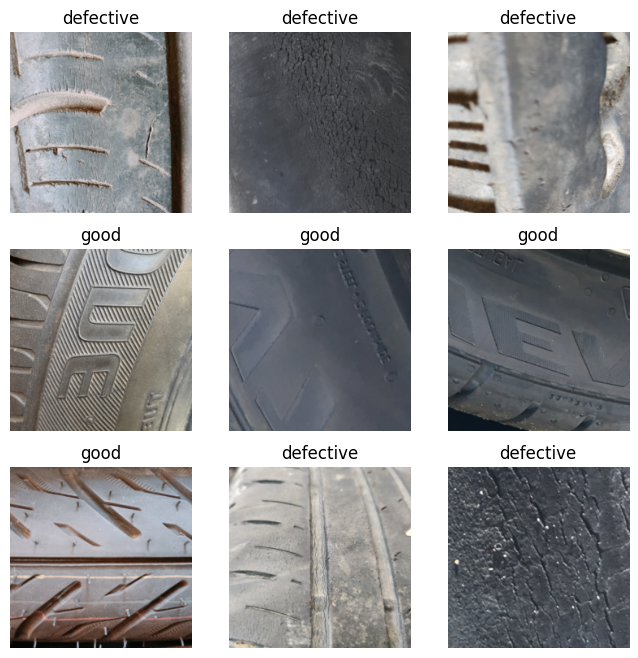

In [ ]:
#@title sanity check by visualizing the dataset

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = test_dataset[sample_idx]
    img = invTrans(img) # inverse the normalization before visualizing, otherwise it would look weird
    figure.add_subplot(rows, cols, i)
    plt.title(id2label[label])
    plt.axis("off")
    plt.imshow(img.T) # have to transpose because expects  M, N, 3
plt.show()

In [ ]:
len(train_dataset)

1484

In [ ]:
len(test_dataset)

372

## Building model

Pretrained model used are from https://github.com/lukemelas/EfficientNet-PyTorch

In [ ]:
#@title Load pre-trained EfficientNetB7

model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=config["classes"])
model._fc= nn.Linear(in_features=model._fc.in_features, out_features=config["classes"], bias=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:15<00:00, 17.1MB/s]


Loaded pretrained weights for efficientnet-b7


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [ ]:
# lr optimizer and loss function
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"], momentum=0.9)

In [ ]:
#@title evaluation function, returns both loss and acc
def evaluation(model, criterion, eval_loader, device):
  # Put the model in evaluation mode
  model.eval()
  total_loss = 0.0
  total_samples = 0.0

  correct, total = 0, 0

  with torch.no_grad():
    for images, labels in eval_loader:
      images = images.to(device)
      labels = labels.to(device)
      # forward pass
      outputs = model(images)

      # calc loss
      loss = criterion(outputs, labels)

      total_loss += loss.item() * images.size(0)
      total_samples += images.size(0)

      # accuracy
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  loss = total_loss/total_samples
  acc = 100*correct/total
  return loss, acc

In [ ]:
num_epochs = config["epochs"]

In [ ]:
type(num_epochs)

int

In [ ]:
#@title train the model
from tqdm.auto import tqdm

with wandb.init(project="efficientnetb7_tyrequality_classifier", config=config):

  # N of data is 1434, with 16 batch size, it would mean having 90 batches on every epoch
  # I want to print 3 loss every batch, so 90/3 = 31
  mini_batch = int((len(train_dataset)/config["batch_size"])/3)

  # tell wandb to watch
  wandb.watch(model, criterion, log="all", log_freq=10)

  example_ct = 0  # number of examples seen
  num_epochs = config["epochs"]
  for epoch in tqdm(range(num_epochs)):
    # change to train mode, because it was eval mode after every epoch
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
      example_ct +=  len(images)
      images, labels = images.to(device), labels.to(device)

      # zero the gradient
      optimizer.zero_grad()

      # forward pass
      outputs = model(images)

      # calc loss
      loss = criterion(outputs, labels)

      # backward pass
      loss.backward()

      # update weights
      optimizer.step()

      # _, preds = torch.max(outputs, 1)
      running_loss += loss.item()

      if (i + 1) % mini_batch == 0:  # report metrics every mini-batches
        # only do train loss
        print(f'epoch [{epoch + 1}/{num_epochs}], batch [{i + 1}/{len(train_loader)}], train/train_loss: {running_loss/mini_batch:.4f}')
        # log to wandb
        wandb.log({"epoch": epoch + 1, "train/loss": loss}, step=example_ct)
        # reset the total loss
        running_loss = 0.0

    eval_loss, eval_acc = evaluation(model, criterion, test_loader, device)

    # after epoch is done, calculate eval
    print(f'eval/accuracy: {eval_acc:.4f}%, eval/loss: {eval_loss:.4f}')
    wandb.log({"test_accuracy": eval_acc})
    wandb.log({"epoch": epoch + 1, "eval/loss": eval_loss}, step=example_ct)



  0%|          | 0/5 [00:00<?, ?it/s]

epoch [1/5], batch [30/93], train/train_loss: 0.6617
epoch [1/5], batch [60/93], train/train_loss: 0.6077
epoch [1/5], batch [90/93], train/train_loss: 0.5534
eval/accuracy: 86.0215%, eval/loss: 0.5220
epoch [2/5], batch [30/93], train/train_loss: 0.5009
epoch [2/5], batch [60/93], train/train_loss: 0.4429
epoch [2/5], batch [90/93], train/train_loss: 0.3804
eval/accuracy: 87.0968%, eval/loss: 0.3978
epoch [3/5], batch [30/93], train/train_loss: 0.3506
epoch [3/5], batch [60/93], train/train_loss: 0.3256
epoch [3/5], batch [90/93], train/train_loss: 0.3328
eval/accuracy: 88.9785%, eval/loss: 0.3203
epoch [4/5], batch [30/93], train/train_loss: 0.3282
epoch [4/5], batch [60/93], train/train_loss: 0.2941
epoch [4/5], batch [90/93], train/train_loss: 0.2658
eval/accuracy: 91.6667%, eval/loss: 0.2621
epoch [5/5], batch [30/93], train/train_loss: 0.2612
epoch [5/5], batch [60/93], train/train_loss: 0.2644
epoch [5/5], batch [90/93], train/train_loss: 0.2657
eval/accuracy: 91.9355%, eval/los

epoch,▁▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆████
eval/loss,█▅▃▂▁
test_accuracy,▁▂▄██
train/loss,█▇▇▆▄▄▃▄▁▂▂▅▁▂▃
epoch,5
eval/loss,0.23415
test_accuracy,91.93548
train/loss,0.34286


In [ ]:
#@title save the model
torch.save(model.state_dict(), 'efficientnetb7_tyrequality_classifier.pth')
# wandb.save("efficientnetb7_tyrequality_classifier.pth")
print('Model saved')

Model saved


In [ ]:
str(eval_acc)

'91.93548387096774'

## Model Inference

In [ ]:
#@title inference

#Write your code for inference here
# please work bro 🙏
from efficientnet_pytorch import EfficientNet
import torch

# Create an instance of the EfficientNet-B7 model
model = EfficientNet.from_name('efficientnet-b7')

# Modify the final classification layer according to your task
# (e.g., replace it with a new layer that matches the number of classes in your task)
model._fc= torch.nn.Linear(in_features=model._fc.in_features, out_features=len(annotations_map), bias=True)

# Load the saved state dictionary
model.load_state_dict(torch.load('/content/efficientnetb7_tyrequality_classifier.pth'))

<All keys matched successfully>

Predicted Class: 0
Predicted Label: defective
Confidence: 76.23444199562073%


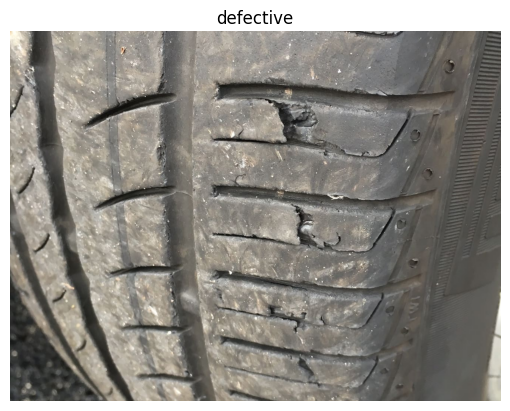

In [ ]:
# Put the model in evaluation mode (important if you have dropout or batch normalization layers)
model.eval()

img = Image.open('/content/defective-tires-cause-accidents-min.jpg')

# Apply the same transformations used during training (resize, normalize, etc.)
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])
input_data = test_transform(img).unsqueeze(0)  # Add a batch dimension

with torch.no_grad():
    output = model(input_data)

# Get the predicted class label
_, predicted_class = torch.max(output, 1)

# Apply softmax to the model's output to get predicted probabilities
probs = torch.nn.functional.softmax(output, dim=1)
conf, _ = torch.max(probs, 1)

# Print the predicted class
print('Predicted Class:', predicted_class.item())
print('Predicted Label:', id2label[predicted_class.item()])
print(f'Confidence: {conf.item()*100}%')

# show image
plt.title(id2label[predicted_class.item()])
plt.axis("off")
plt.imshow(img) # have to transpose because expects  M, N, 3
plt.show()

In [ ]:
probs

tensor([[0.7623, 0.2377]])

# unused codes

In [ ]:
model = efficientnet_b7(weights='DEFAULT')
# Torchvision >= 0.11 includes EfficientNet, and it does have a classifier attribute. To get the in_features :
num_ftrs = model.classifier[1].in_features
model.fc = nn.Linear(num_ftrs, len(annotations_map))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
#not used

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:04<00:00, 60.6MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [ ]:
import torchvision.models as models
import requests
from PIL import Image
from torchvision import transforms
import io

model2 = models.efficientnet_b7(weights=None)
model_weights_path = 'v3_efficientnetb7_tyrequality_classifier.pth'  # Path to the saved model weights on your local disk
model2.load_state_dict(torch.load(model_weights_path))

RuntimeError: ignored

### alternative using hugging face's trainer API

In [ ]:
# Load pre-trained EfficientNetB7

from transformers import AutoImageProcessor

checkpoint = 'google/efficientnet-b7'
image_processor = AutoImageProcessor.from_pretrained(checkpoint)


In [ ]:
from transformers import EfficientNetForImageClassification

model = EfficientNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(annotations_map),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b7 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 2560]) in the checkpoint and torch.Size([2, 2560]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import DefaultDataCollator

# data_collator = DefaultDataCollator()

In [ ]:
import evaluate
import numpy as np

accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
# Training Args
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="model/pytorch-tyre-classification-efficientnetb7",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,                 # learning rate
    per_device_train_batch_size=32,     # training batch size
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,        # model optimization via early stopping
    metric_for_best_model="accuracy",
    push_to_hub=True, # When set to True, this allows the trained model to be directly uploaded to the Hugging Face Model Hub.
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_loader.dataset,
    eval_dataset=test_loader.dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [ ]:
for data in train_loader.dataset:
    print(data)
    break

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

In [ ]:
trainer.train()

AttributeError: ignored

In [ ]:
#Write your code to build your model here

accuracy = 0 #if you change the name of your accuracy variable, change the name also in the submit parameter



FIN